<a href="https://colab.research.google.com/github/pakrentos/eeg_connectivity/blob/master/mlp_eeg_Pavel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install h5py

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp as ivp
from scipy.signal import butter, lfilter
from matplotlib import pyplot as plt
from os.path import join
import time
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import keras.metrics as metrics
from sklearn import preprocessing
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import math
import os
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
###Added
import seaborn as sns
import pandas as pd
from keras.wrappers.scikit_learn import KerasRegressor

Оскиллатiр

In [ ]:
def normalize(arr):
    shape = arr.shape
    its = 1
    size = shape[-1]
    temp_arr = arr.flatten()
    for shape_i in shape:
        its *= shape_i
    its //= size
    for i in range(its - 1):
        temp_slice = temp_arr[i*size : (i+1)*size]
        temp_arr[i*size : (i+1)*size] = (temp_slice - np.min(temp_slice))/(np.max(temp_slice) - np.min(temp_slice))
    temp_slice = temp_arr[(i+1)*size:]
    temp_arr[(i+1)*size:] = (temp_slice - np.min(temp_slice))/(np.max(temp_slice) - np.min(temp_slice))
    return temp_arr.reshape(*shape)

In [ ]:
def rossler(t, vec: np.array):
    res = np.zeros(6)
    x = vec[0:4:3]
    y = vec[1:5:3]
    z = vec[2:6:3]
    res[0:4:3] = -omega*y - z + epsylon*(x[::-1] - x)
    res[1:5:3] = omega*x + a*y
    res[2:6:3] = p + z*(x-c)
    return res
a = 0.15
p = 0.2
c = 10
omega = np.array([0.99, 0.95])
eps = 0
X1 = 0
Y1 = 1
Z1 = 2
X2 = 3
Y2 = 4
Z2 = 5

epsylon = np.array([0.15, 0.15])
fps = 250
start_time = 0
end_time = 375
t=np.linspace(start_time, end_time, num=int(fps*end_time))
z0 = np.zeros(6)
res1 = ivp(rossler, (start_time,end_time), z0, t_eval=t)
y = res1['y'] # тут данные с шейпом (6, <fps*(end_time - start_time)>). Эти шесть временных рядов -- значения x1, y1, z1, x2, y2, z2 соответственно
t_span = res1['t'] # тут время (можно использовать то, что выше)
norm_osc_data = normalize(y)[::, fps*100:]
osc1 = norm_osc_data[0:3].T # матрица вида [[X1_1, Y1_1, Z1_1], [X1_2, Y1_2, Z1_2], [X1_3, Y1_3, Z1_3], ...]
osc2 = norm_osc_data[3:6].T # то же самое, что сверху, но только для X2, Y2, Z2

Обработка данных

In [ ]:
sfq = 250
wnd = 1
bias = 2
times = 12

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
class CrossWindow():
  
  def __init__(self, arr, n, add_tail=False):
    assert len(arr.shape) == 1
    sh = arr.shape[0]
    assert n < sh
    if sh%n == 0:
        self.arr = arr.reshape(n, sh//n)
    else:
        if add_tail:
            print(f'Warning: impossible to fit array in shape ({n}, {sh//n}), remaining tail will have size {sh%n}')
            self.arr = arr[:n*sh//n].reshape(n, sh//n)
        

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [ ]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def coeff_determination_simp(y_true, y_pred):
    res = np.sum(np.square(y_true - y_pred))
    y_true_mean = np.tile(np.mean(y_true, axis=-1), y_true.shape[-1]).reshape((y_true.shape[-1], y_true.shape[-2])).T
    tot = np.sum(np.square(y_true - y_true_mean))
    return 1 - res/((tot + K.epsilon())*y_true.shape[0]*y_true.shape[1])

In [ ]:
mapping = [
    ('O2','A2'),
    ('O1','A1'),
    ('P4','A2'),
    ('P3','A1'),
    ('C4','A2'),
    ('C3','A1'),
    ('F4','A2'),
    ('F3','A1'),
    ('Fp2','A2'),
    ('Fp1','A1'),
    ('T6','A2'),
    ('T5','A1'),
    ('T4','A2'),
    ('T3','A1'),
    ('F8','A2'),
    ('F7','A1'),
    ('Oz','A2'),
    ('Pz','A1'),
    ('Cz','A2'),
    ('Fz','A1'),
    ('Fpz','A2'),
    ('FT7','A1'),
    ('FC3','A1'),
    ('Fcz','A1'),
    ('FC4','A2'),
    ('FT8','A2'),
    ('TP7','A1'),
    ('CP3','A1'),
    ('Cpz','A1'),
    ('CP4','A2'),
    ('TP8','A2'), 
]
r_mapping = {mapping[i][0]:i for i in range(len(mapping))}
    

In [ ]:
def normalize(arr:np.array):
    return (arr - arr.min())/(arr.max()-arr.min())

In [ ]:
def extract(data_stream):
    raw_data = data_stream.readlines()
    data = []
    for line in raw_data:
        temp = np.array([float(x) for x in line.split()])
        data.append(temp)
    return np.array(data)

def format_fname(_group, _hand, _subj, _tr_num):
    directory = 'D:\\Jupyterlabs\\Assignment\\Subjects'
    fname_pattern = f'{_group}_subject_{_subj}_{_hand}_tr_{_tr_num}.dat'
    return join(directory, fname_pattern)

hands = ('lefthand', 'righthand')
groups = ('OLD', 'YOUNG')
subjects = np.arange(1, 11)
trials = np.arange(1, 16)
total = len(hands)*len(groups)*len(subjects)*len(trials)

In [ ]:
epochs = []

for trial in trials:
    fin = open(format_fname('YOUNG', hands[1], subjects[0], trial))
    epochs.append(extract(fin))
    fin.close()

epochs = np.array(epochs)

In [ ]:
t = np.linspace(0, 12, 3001)
tp7 = epochs[::, r_mapping['TP7'], ::]
cz = epochs[::, r_mapping['Cz'], ::]
lowcut = 8.0
highcut = 12.0
cz_filtered = butter_bandpass_filter(cz, lowcut, highcut, sfq, order=6)
tp7_filtered = butter_bandpass_filter(tp7, lowcut, highcut, sfq, order=6)
tp7_filtered = np.array([(tp7_filtered[i] - np.min(tp7_filtered[i]))/(np.max(tp7_filtered[i]) - np.min(tp7_filtered[i])) for i in range(len(tp7_filtered))])
cz_filtered = np.array([(cz_filtered[i] - np.min(cz_filtered[i]))/(np.max(cz_filtered[i]) - np.min(cz_filtered[i])) for i in range(len(cz_filtered))])

In [ ]:
tp7_filtered = tp7_filtered.T
cz_filtered = cz_filtered.T
print(tp7_filtered.shape, cz_filtered.shape)

(3001, 15) (3001, 15)


Создание и тестирование нейросети

In [ ]:
class EarlyStopDifference(keras.callbacks.Callback):
    # Custom callback that stops training if the difference between training and validation
    # loss function is more than delta for the past patience training epochs
    
    ### Parameters:
    ### delta: Integer, default=0; Minimal affordable difference between loss functions
    ### patience: Integer, default=0; Number of epochs it is tolerable to have difference greater than delta
    ### verbose: Integer, default=0; Prints output if it is 1
    
    def __init__(self, patience=0, delta=0, verbose=0):
        # Initializing parameters
        super(EarlyStopDifference, self).__init__()
        self.patience=patience
        self.delta=delta
        self.verbose=verbose
        self.counter=0
    
    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        # Recieving loss function values
        mse = logs['loss']
        val_mse = logs['val_loss']
        # Comparing them to delta
        if ((mse - val_mse) <= self.delta):
            # Resetting counter
            self.wait = 0
        else:
            # Incrementing counter
            self.wait += 1
            if self.wait >= self.patience:
                # Stopping the model if wait >= patience
                self.stopped_epoch = epoch
                self.model.stop_training = True
                if (self.verbose != 0):
                    print("Model stopped because mse and val_mse differ for more than ", self.delta, " for the past ", self.patience, " training epochs.")
            
    def on_train_end(self, logs=None):
        # Printing the epoch the model has stopped
        if (self.stopped_epoch > 0) & (self.verbose != 0):
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))   

    

Создание модели

In [ ]:
### Added
#Создание модели
def baseline_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(1, activation='linear'))
    model.add(layers.Dense(10, activation='softmax'))
    model.add(layers.Dense(10, activation='softmax'))
    model.add(layers.Dense(1, activation='linear'))
    #Компиляция модели
    model.compile(loss='mse', optimizer=tf.optimizers.Adam(0.001), metrics=[coeff_determination])
    return model

Early Stopping and checkpointing

In [ ]:
model_dir = 'D:\\Jupyterlabs\\Assignment\\saved_models\\best_model.h5'

In [ ]:
my_callbacks = [
#     tf.keras.callbacks.ModelCheckpoint(model_dir, monitor='coeff_determination', verbose=0, mode='max', save_best_only=True),
    EarlyStopDifference(patience=10, delta=0.001, verbose=0),
#     tf.keras.callbacks.EarlyStopping(mode='min', patience=50, min_delta=0.001),
#     tf.keras.callbacks.EarlyStopping(monitor='coeff_determination', mode='max', baseline=0.6, patience=20, min_delta=0.01)
]

Выделение тренировочного множества и его нормализация

In [ ]:
### Тренируем сетку
src = cz_filtered[5*int(sfq*wnd):6*int(sfq*wnd), 0:1]
trgt = tp7_filtered[5*int(sfq*wnd):6*int(sfq*wnd), 0:1]
src = normalize(src)
trgt = normalize(trgt)

Валидационное множество и его создание


In [ ]:
### Validation set
src_predict1 = cz_filtered[9*int(sfq*wnd):10*int(sfq*wnd), 3:4]
trgt_predict1 = tp7_filtered[9*int(sfq*wnd):10*int(sfq*wnd), 3:4]
src_predict1 = normalize(src_predict1)
trgt_predict1 = normalize(trgt_predict1)

In [ ]:
tf.keras.backend.set_floatx('float64')

In [ ]:
### Model
model = baseline_model()
histories = model.fit(src, trgt, callbacks=my_callbacks, validation_data=(src_predict1, trgt_predict1), epochs=15, batch_size=32, verbose=0)
### Prediction results
res = model.predict(src_predict1, batch_size=100)
mse = np.square(np.subtract(res, trgt_predict1)).mean()
print('R Squared: ', r2_score(trgt_predict1, res), "; MSE: ", mse)

R Squared:  -0.8358743934072281 ; MSE:  0.0973818734784134


In [ ]:
histories.history['val_coeff_determination'][-1]

-0.007224893846243363

Cross-validation

In [ ]:
### Source: https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/ https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/
# skf = StratifiedKFold(n_split = 5, random_state = 7, shuffle = True)

### Эту функцию можно вызывать
def K_fold(inputs:np.array, targets:np.array, num_folds):
    
    kfold = KFold(n_splits=num_folds, shuffle=True)
    cross_validation(inputs, targets, kfold)

### Эту функцию можно вызывать
def Time_Series_Split(inputs:np.array, targets:np.array, num_folds):
    
    Spl = TimeSeriesSplit(n_splits=num_folds)
    cross_validation(inputs, targets, Spl)
    
### Эту функцию можно вызывать
def Shuffle_Split(inputs:np.array, targets:np.array, num_folds):

    Spl = Shuffle_Split(n_splits=num_folds)
    cross_validation(inputs, targets, Spl)

### Вспомогательная функция
def cross_validation(inputs:np.array, targets:np.array, cross_val):

    def get_model_name(k):
        return 'model_'+str(k)+'.h5'
    
    num_epochs = 25

    acc_per_fold = []
    loss_per_fold = []

    save_dir = 'D:\\Jupyterlabs\\Assignment\\saved_models\\'
    fold_no = 1

    num_epochs = 500

    for train, test in cross_val.split(inputs, targets):
        
        # CREATE NEW MODEL
        model = baseline_model()
    
        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')
    
        # CREATE CALLBACKS
        checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
                                                        verbose=0, save_best_only=True)
        callbacks_list = [checkpoint]
        # There can be other callbacks, but just showing one because it involves the model name
        # This saves the best model
        # FIT THE MODEL
        history = model.fit(inputs[train], targets[train],
                            epochs=num_epochs, callbacks=callbacks_list,
                            validation_data=(inputs[test], targets[test]), verbose=0)
        #PLOT HISTORY
        #:
        
        #:
    
        # LOAD BEST MODEL to evaluate the performance of the model
        model.load_weights("D:\\Jupyterlabs\\Assignment\\saved_models\\"+get_model_name(fold_var))
        results = model.evaluate(inputs[test], targets[test], verbose=0)
        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {results[0]}; {model.metrics_names[1]} of {results[1]*100}%')
    
        acc_per_fold.append(results[1] * 100)
        loss_per_fold.append(results[0])
    
        tf.keras.backend.clear_session()
    
        fold_no += 1

    # == Provide average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - R Squared: {acc_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Coefficient of Determination: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print('-------------------------------------------------------------------')
    return np.mean(loss_per_fold)

Time_Series_Split(src_predict1, trgt_predict1, 7)

------------------------------------------------------------------------
Training for fold 1 ...


NameError: name 'fold_var' is not defined

Визуализация

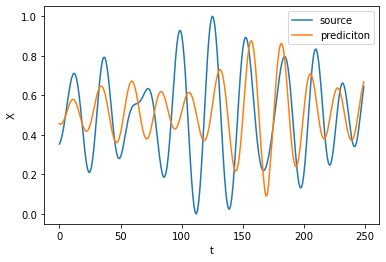

In [ ]:
### Данные, которые мы предсказываем
a = range(0, 250)
plt.figure()
plt.plot(a, trgt_predict1[:, :], label='source')
plt.plot(a, res, label='prediciton')
plt.xlabel('t')
plt.ylabel('X')
plt.legend()
plt.show()

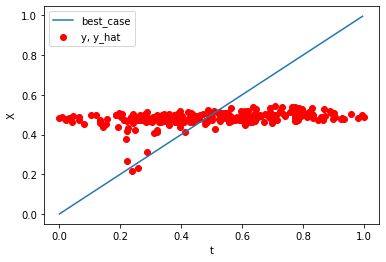

In [ ]:
### Данные, которые мы предсказываем
a=[]
for i in range(0, 250):
    a.append(i/250)
plt.figure()
plt.plot(a, a, label='best_case')
plt.scatter(trgt_predict1[:, :], res, label='y, y_hat', color='r')
plt.xlabel('t')
plt.ylabel('X')
plt.legend()
plt.show()

In [ ]:
a = pd.DataFrame(histories.history)
a.describe()

,loss,coeff_determination,val_loss,val_coeff_determination
count,59.000000,59.000000,59.000000,59.000000
mean,0.060478,0.248469,0.050367,0.116094
std,0.027811,0.349558,0.009238,0.210823
min,0.054922,-2.325356,0.047261,-1.043058
25%,0.054974,0.304638,0.047719,0.162720
50%,0.055034,0.316433,0.047944,0.171764
75%,0.055332,0.320760,0.048333,0.176654
max,0.264994,0.328304,0.101204,0.186966


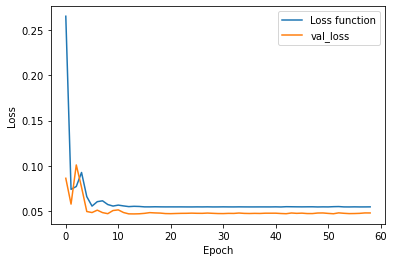

In [ ]:
###ADDED
### Рисует график обучения (loss function) и график метрики (coeff_determination). Своровано и адаптировано отсюда: https://www.tensorflow.org/tutorials/keras/regression?hl=ru
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
           label = 'Loss function')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'val_loss')
    plt.legend()
    plt.show()


plot_history(histories)

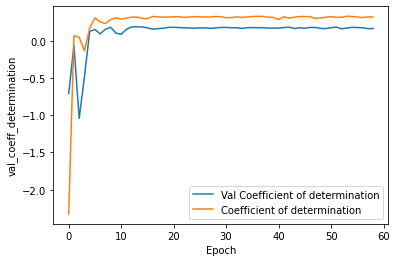

In [ ]:
def plot_history2(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('val_coeff_determination')
    plt.plot(hist['epoch'], hist['val_coeff_determination'],
           label='Val Coefficient of determination')
    plt.plot(hist['epoch'], hist['coeff_determination'],
           label='Coefficient of determination')
    plt.legend()
    plt.show()


plot_history2(histories)

In [ ]:
hist = pd.DataFrame(histories.history)
hist.describe()

,loss,coeff_determination,val_loss,val_coeff_determination
count,59.000000,59.000000,59.000000,59.000000
mean,0.060478,0.248469,0.050367,0.116094
std,0.027811,0.349558,0.009238,0.210823
min,0.054922,-2.325356,0.047261,-1.043058
25%,0.054974,0.304638,0.047719,0.162720
50%,0.055034,0.316433,0.047944,0.171764
75%,0.055332,0.320760,0.048333,0.176654
max,0.264994,0.328304,0.101204,0.186966


Проверка нахождения связей

In [ ]:
### Проверка нахождения связей
coefs = {}
for tr in range(15):
    start_time = time.time()
    temp = []
    for i in range(int(math.floor(2/wnd)), int(times/wnd)-1):
        model = baseline_model()
        src = cz_filtered[int(sfq*wnd*i):int(sfq*wnd*(i+1)), tr:tr+1]
        trgt = tp7_filtered[int(sfq*wnd*(i+1)):int(sfq*wnd*(i+2)), tr:tr+1]
        src = normalize(src)
        trgt = normalize(trgt)
        model.fit(src, trgt, epochs=500, batch_size=32, verbose=False, validation_split=0.3)
        src_full = cz_filtered[int(sfq*wnd*i):int(sfq*wnd*(i+1)):5, tr:tr+1]
        trgt_full = tp7_filtered[int(sfq*wnd*(i+1)):int(sfq*wnd*(i+2)):5, tr:tr+1]
        src_full = normalize(src)
        trgt_full = normalize(trgt)
        res = model.predict(src, verbose=False)
        c = r2_score(trgt, res)
#         estimator = KerasRegressor(build_fn=baseline_model, epochs=500, batch_size=32, verbose=0)
#         kfold = KFold(n_splits=10)
#         results = cross_val_score(estimator, src, trgt, cv=kfold)
        temp.append(c)
        print(f'Current trial: {tr} ### Second: {i*wnd}-{(i+1)*wnd} ### R Squared score: {c} ### Time of exec: {time.time() - start_time} seconds')
    coefs[tr] = temp
    print('@@@ New trial @@@')

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x000002CFCAF693A8>
Traceback (most recent call last):
  File "c:\users\pavel\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\data\ops\iterator_ops.py", line 538, in __del__
    handle=self._handle, deleter=self._deleter)
  File "c:\users\pavel\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\ops\gen_dataset_ops.py", line 1139, in delete_iterator
    tld.op_callbacks, handle, deleter)
KeyboardInterrupt: 


Current trial: 0 ### Second: 2-3 ### R Squared score: 0.40435435652402973 ### Time of exec: 20.323434352874756 seconds
Current trial: 0 ### Second: 3-4 ### R Squared score: 0.010525689203815247 ### Time of exec: 41.4996542930603 seconds
Current trial: 0 ### Second: 4-5 ### R Squared score: -0.0931036889260588 ### Time of exec: 62.03890347480774 seconds
Current trial: 0 ### Second: 5-6 ### R Squared score: -0.04280220095469245 ### Time of exec: 83.12332391738892 seconds
Current trial: 0 ### Second: 6-7 ### R Squared score: 0.2477777185398098 ### Time of exec: 102.72723412513733 seconds
Current trial: 0 ### Second: 7-8 ### R Squared score: 0.10470086835575598 ### Time of exec: 121.59440350532532 seconds
Current trial: 0 ### Second: 8-9 ### R Squared score: 0.14579403043722183 ### Time of exec: 141.40838170051575 seconds
Current trial: 0 ### Second: 9-10 ### R Squared score: 0.01902184524406192 ### Time of exec: 160.87091040611267 seconds
Current trial: 0 ### Second: 10-11 ### R Squared s

KeyboardInterrupt: 

In [ ]:
coefs = list(coefs.values())

In [ ]:
coefs = np.array(coefs)

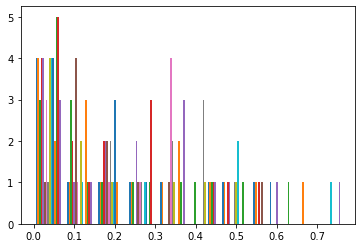

In [ ]:
plt.hist(coefs.T)
plt.show()

In [ ]:
coefs.shape # 15 триалов, в каждом по 9 окон. массив хранит данные о фите для каждого окна

(15, 9)

In [ ]:
len(coefs[0].shape)

1